# Exercise: Hierarchical Cluster Analysis
You are provided with a dataset containing demographic indicators for 36 European countries. These include variables such as:

- birth and death rates  
- male and female life expectancy  
- total population and population density

Your goal is to uncover clusters of countries that share similar demographic profiles. To do this, proceed as follows:

- Design and implement a **machine learning pipeline** that prepares your data for clustering.
- Use **PCA** to reduce the dimensionality of the data and support your interpretation.
- Apply **hierarchical clustering** to identify meaningful groups of countries.
- Visualize your results using a **dendrogram**, and analyze the outcome.
- Investigate and compare **different linkage methods** (`ward`, `complete`, `average`, etc.). Justify your final choice.
- Characterize each resulting cluster: What do the countries in each group have in common? How do they differ from others?


In [1]:
import pandas as pd

df = pd.read_csv("europe_demo_cleaned.csv")

In [2]:
df.dtypes

country_name               object
birth_rate                float64
death_rate                float64
male_life_expectancy      float64
female_life_expectancy    float64
population                float64
population_per_sq_km      float64
dtype: object

In [3]:
pd.isnull(df).sum()

country_name              0
birth_rate                0
death_rate                0
male_life_expectancy      0
female_life_expectancy    0
population                0
population_per_sq_km      0
dtype: int64

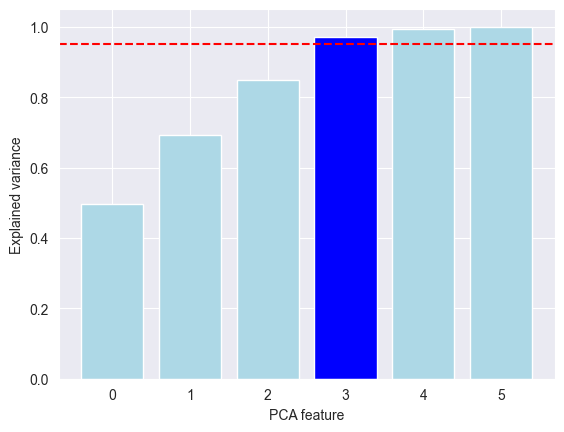

In [4]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

# get rid of country name, not needed for clustering
data = df.drop(columns=["country_name"])

# no pipeline for assessing the number of pca components, comes later
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

pca_assess = PCA()
pca_assess.fit(data_scaled)

# I decided to plot the explained variance as cumulative ratios and choose the number of pca components based on that
# I put a line at 95% and chose the number of the bar that first penetrates the line (here: n=4)
cumulative_variance = np.cumsum(pca_assess.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= 0.95) + 1
features = range(pca_assess.n_components_)
colors = ['lightblue'] * len(features)
colors[n_components - 1] = 'blue'

plt.bar(features, cumulative_variance, color=colors)
plt.axhline(y=0.95, color='r', linestyle='--')
plt.xlabel('PCA feature')
plt.ylabel('Explained variance')
plt.xticks(features)
plt.show()

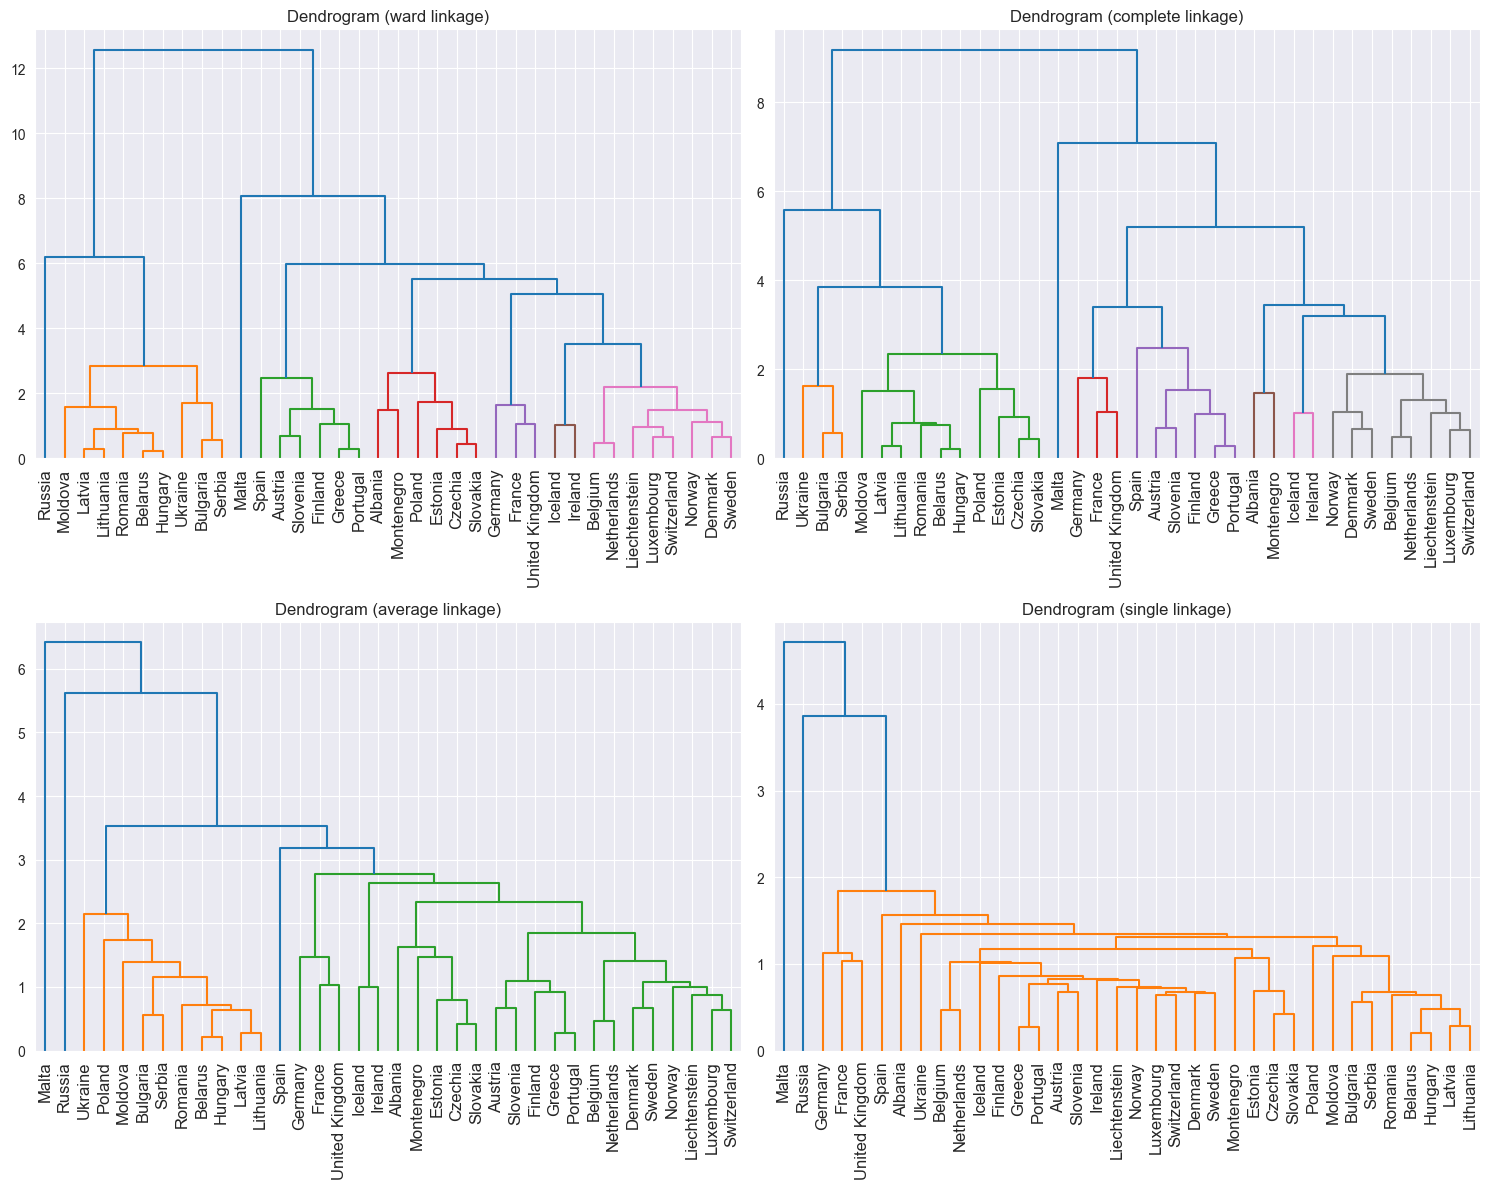

In [5]:
from scipy.cluster.hierarchy import linkage, dendrogram

pca = PCA(n_components=n_components)
pipeline = make_pipeline(scaler, pca)

data_pca = pipeline.fit_transform(data)

# Perform hierarchical clustering with different linkage methods
# chose the color threshold manually, to my liking
linkage_methods = ["ward", "complete", "average", "single"]
plt.figure(figsize=(15, 12))
for i, method in enumerate(linkage_methods, 1):
    plt.subplot(2, 2, i)
    hiera = linkage(data_pca, method=method)
    dendrogram(hiera, labels=df["country_name"].values, leaf_rotation=90, color_threshold=3)
    plt.xticks(fontsize=12)
    plt.title(f"Dendrogram ({method} linkage)")

plt.tight_layout()
plt.show()

I would choose complete linkage, as the clustering makes sense, based on my knowledge as a european. It clusters the countries into the countries who were influenced and controlled by russia til 1990. They (must) have more in common, then the other countries. Malta being solo also makes sense as it's a very small island off the main land of europe with the southernmost capitol. It also groups very similar/close countries well, e.g. Albania/Montenegro, Iceland/Ireland, Denmark/Sweden/Norway... , Germany/France/UK, etc.

Ward also looks kind of good, but isn't as clear as the complete method (in my opinion)

In [6]:
from scipy.cluster.hierarchy import fcluster

# Perform hierarchical clustering with "complete" linkage
final_hiera = linkage(data_pca, method="complete")
clusters = fcluster(final_hiera, t=3, criterion='distance')

df['cluster'] = clusters

print(df.sort_values(by='cluster'))

      country_name  birth_rate  death_rate  male_life_expectancy  \
17         Ukraine         7.8        15.9                  66.4   
9         Bulgaria         8.5        18.0                  69.9   
33          Serbia         8.9        16.9                  71.4   
10         Czechia        10.3        12.1                  75.3   
23          Latvia         9.2        15.2                  70.9   
16        Slovakia        10.4        10.8                  73.5   
14         Romania         9.2        15.4                  70.5   
13          Poland         9.4        12.6                  72.6   
12         Moldova         9.8        11.8                  67.7   
11         Hungary         9.6        14.5                  72.3   
19         Estonia         9.9        11.9                  74.2   
8          Belarus         9.3        13.0                  69.3   
24       Lithuania         9.0        15.6                  70.1   
15          Russia         9.8        14.6      

Characterize every cluster:

**Cluster 1**: Countries like Ukraine, Bulgaria and Serbia have high death rates and lower life expectancies, especially for males. Their populations are kind of medium-sized.

**Cluster 2**: Latvia, Lithuania, Moldova and more have moderate to higher death rates, moderate birth rates and higher life expectancy than cluster one and smaller to medium populations.

**Cluster 3**: Just Russia, huge difference in Population and Population/sq km. Rest is kind of similar to cluster one and two.

**Cluster 4**: UK, Germany, France - high life expectancy, big population

**Cluster 5**: Spain, Portugal, Finland ... Similar to cluster 4, but smaller populations.

**Cluster 6**: Albania, Montenegro - higher birth rates, lower life expectancy

**Cluster 7**: Iceland Ireland - very low death rates, small populations.

**Cluster 8**: Very high life expectancy, medium in everything else (most of it at least)

**Cluster 9**: Malta, opposite to russia, low population but huge population/sq km. Rest is quite uninteresting, moderate birth and death rates and high life expectancy.